# Model V7

Last updated dataset (May 2023). Tokenizer transform named entity with a special label
Unbalanced dataset : Number of neutral pairs is 5 times as much as number of entailement pairs

In [5]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation

In [7]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [8]:
# CHECK GPU hardware

!nvidia-smi

Fri Jun 16 19:09:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:5E:00.0 Off |                  Off |
| 30%   24C    P8    16W / 230W |   2349MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading trained model

In [9]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v7')
dm.prepare_data()
dm.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'v7/run=0_vector=fasttext_lentropy=0'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

16-06-2023 19:09:46 |     INFO   archival_module.py:prepare_data:102  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/v7/vocab.pt
16-06-2023 19:09:46 |     INFO   archival_module.py:prepare_data:102  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/v7/vocab.pt
16-06-2023 19:09:46 |     INFO   archival_module.py:prepare_data:104  Vocab size: 14543
16-06-2023 19:09:46 |     INFO   archival_module.py:prepare_data:104  Vocab size: 14543
16-06-2023 19:09:47 |     INFO   dataset.py:__init__:86  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v7/test.json
16-06-2023 19:09:47 |     INFO   dataset.py:__init__:86  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v7/test.json
16-06-2023 19:09:47 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
16-06-2023 19:09:47 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
Model is in cuda:  True


In [10]:
data = dm.test_set.data
data_entail = data[data['label'] == 'entailment']
for idx, row in data_entail[:10].iterrows():
    print(row['premise.text'] + ' '+ row['hypothesis.text'])
    print()

Ce retard empêche par lui-même nos entreprises de résoudre plus rapidement les problèmes économiques qu'elles rencontrent.  Il grève et contrarie aussi le développement de l'autogestion et des rapports économiques internes. 

Au début, les initiatives étaient toujours prises par le groupe initial (fondateur) et l'on risquait de voir la coopérative se transformer (ô désastre) en entreprise et les participants réagir en employés.  Sur ce plan, la situation tend à s'améliorer. 

Les ouvriers donneront du tissu, du fer aux paysans qui, en échange, donneront du pain.  Je viens de voir un camarade de Ivanovo-Vosnesson:k. Il m'a exposé que c'était là l'essentiel. 

L'initiation matrimoniale, malgré l'évidence de sa valeur-signe, s'insère dans les limites contraignantes de l'échange symbolique.  Quatre grande étapes rythment cette cérémonie complexe, depuis l'annonce publique jusqu'à l'initiation proprement dite. 

Une des formes conçues à l'origine par l'homme, qui se sont aliénées pour exerc

# Evaluation in generated test set

## Model's predictions

### Evaluate accuracy

In [11]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.9938, device='cuda:0')

Precision / Recall curve 

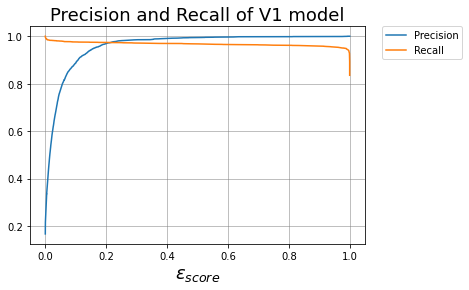

In [12]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall of V1 model', fontsize=18)
plt.show()

Distribution

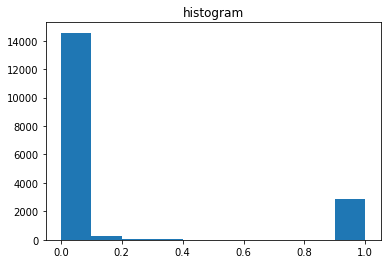

In [13]:
y_score = all_y_hat.cpu().numpy()

plt.hist(y_score) 
plt.title("histogram") 
plt.show()

## Model's attention map

In [14]:
import pandas as pd

df_inference = pd.DataFrame()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    padding_mask = batch['padding_mask']
    B = len(y_true)
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {side: a_hat[side].softmax(-1) for side in a_hat}
    a_hat = { side : [ attention[i][~padding_mask[side][i]].tolist()  for i in range(B) ] for side, attention in a_hat.items() }

    inferench_batch = {}
    for side in ['premise', 'hypothesis']:
        COLUMNS = [side + '.norm', side + '.form']
        inferench_batch.update({c : batch[c] for c in COLUMNS})
        inferench_batch.update({side + '.attention' : a_hat[side]})



    inferench_batch['y_true'] = batch['y_true'].tolist()
    inferench_batch['y_score'] = y_hat.tolist()
    
    inferench_batch = pd.DataFrame(inferench_batch)
    
    df_inference = pd.concat([df_inference, inferench_batch])
    
df_inference.reset_index(drop=True, inplace=True)

In [15]:
EPSILON_Y_HAT = 0.8

df_inference['y_hat'] = df_inference['y_score'] > EPSILON_Y_HAT

df_true_positive = df_inference[df_inference['y_hat'] & df_inference['y_true']]
df_true_positive.reset_index(drop=True, inplace=True)

print('% True positive:', len(df_true_positive) / len(df_inference))
print('# True positive:', len(df_true_positive))

% True positive: 0.16030962530850348
# True positive: 2858


In [16]:
from modules import highlight
BEGIN = 0
END = 10    

html='<table>'
html += '<thead><tr><th>Index</th> <th>Premise</th> <th>Hypothesis</th> <th>Score</th> </tr></thead>'

for idx, row in df_true_positive[BEGIN:END].iterrows():
    
    idx = str(row.name)
    #premise = [tk['form'] for tk in s_tokens]
    premise = highlight(row['premise.form'], row['premise.attention'])

    #hypothesis = ' '.join([tk['form'] for tk in t_tokens])
    hypothesis = highlight(row['hypothesis.form'], row['hypothesis.attention'])

    score = str(round(row['y_score'], 2))
    
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +premise + '</td>' + '<td>' + hypothesis + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

Words received most of attention weight

In [17]:
import numpy as np
import json

ATTENDED_TOKEN_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions', 'words_attention_mass.json')

if path.exists(ATTENDED_TOKEN_PATH):
    
    # Load the attention mass if the file exits
    with open(ATTENDED_TOKEN_PATH, 'r') as f:
        avg_attention_mass = json.load(f)
else:

    # flatten and align tokens and attentions
    tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
    attentions = np.concatenate(df_true_positive['premise.attention'].tolist()).tolist()
    assert len(tokens) == len(attentions), 'Not compatible length'

    # cumulate attention weights
    attention_mass = {}
    word_occurence = {}
    for w, a in zip(tokens, attentions):
        # w : word
        # a : attention weight
        attention_mass[w] = attention_mass.get(w, 0) + a
        word_occurence[w] = word_occurence.get(w, 0) + 1

    # renormalized by the word frequency 
    avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}
        
    # sort by descending order
    avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

    # Save to file
    os.makedirs(path.dirname(ATTENDED_TOKEN_PATH))
    with open(ATTENDED_TOKEN_PATH, 'w') as f:
        json.dump(avg_attention_mass, f)

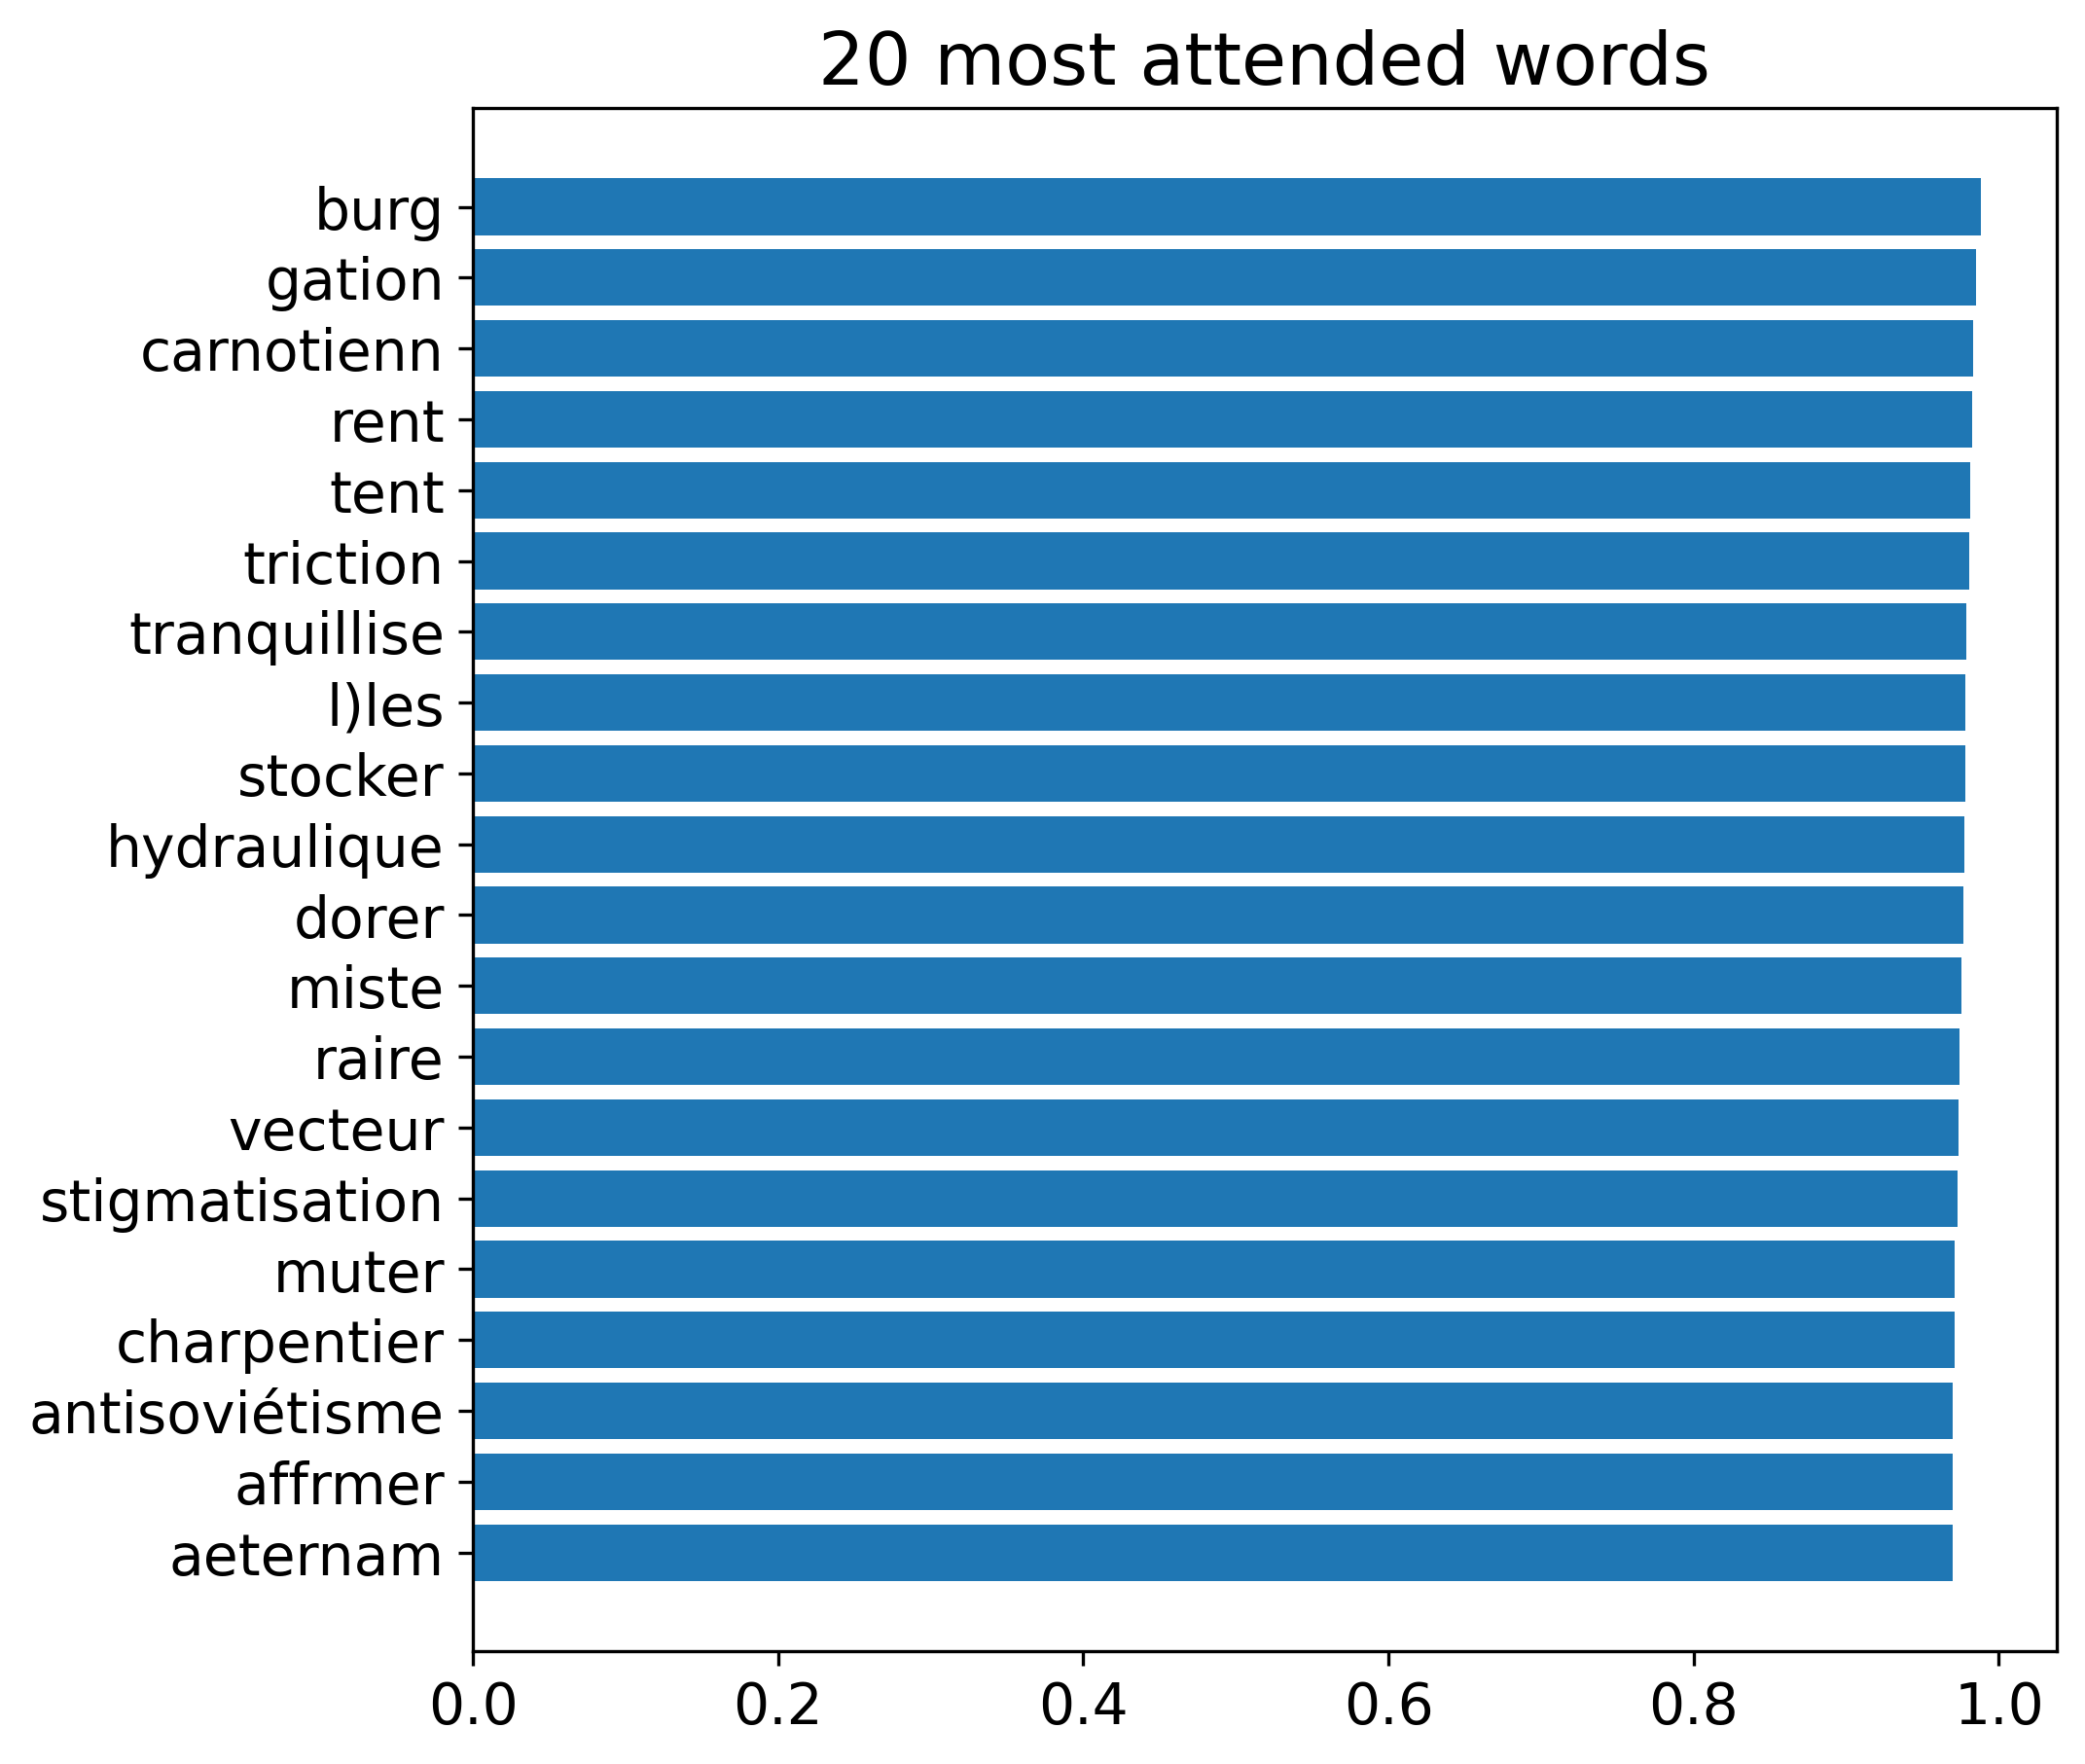

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['figure.dpi'] = 300

N_WORDS = 20
x = list(avg_attention_mass.keys())[:N_WORDS]
y = list(avg_attention_mass.values())[:N_WORDS]
plt.barh(x[::-1], y[::-1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'{N_WORDS} most attended words', fontsize=18)

fig_path = path.join(tmp_path, 'figures')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(path.join(fig_path, f'average_attn_mass_xnli.png'),dpi=100)
plt.show()

# Evaluation in a subset

In [19]:
%%time
import pandas as pd

std_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'std_block_links.json')
df_std_block_links = pd.read_json(std_block_links_path, dtype={'link.type':'category'})

block_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'blocks.v2.json')
df_block = pd.read_json(block_path, encoding='utf-8')

CPU times: user 5.5 s, sys: 1.77 s, total: 7.26 s
Wall time: 7.24 s


In [20]:
article_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'articles.v2.json')
df_article = pd.read_json(article_path)
df_article.set_index('id', inplace=True)

In [21]:
# Format df_block , create uid index for easy access
df_block['uid'] = df_block['page.id.fmsh'] + '_' + df_block['block.id'].astype(str).str.zfill(2)
df_block = df_block.set_index('uid')

In [22]:
from modules.archival import *
from modules import *

In [23]:
df_block = df_block.rename(columns={'sentences': 'sents'})

## Study on an example link

In [24]:
#Get a link
link = df_std_block_links.iloc[1000]

source_revue_id = link['source.revue.id.persee']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.bloc.id']

# get uid
block_uid = { side: link[f'{side}.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model, idx_class=1)

In [25]:
# Prepare the tokens
block_words = {'source': [], 'target': []}
for side in block_words:
    block_form = get_block(df_block, block_uid[side], 'form')
    block_space = [[(' ' if s else '') for s in sent_s] for sent_s in get_block(df_block, block_uid[side], 'space_after')]
    block_words[side] = [[f+s for f, s in zip(block_f, block_s)] for block_f, block_s in zip(block_form, block_space)]

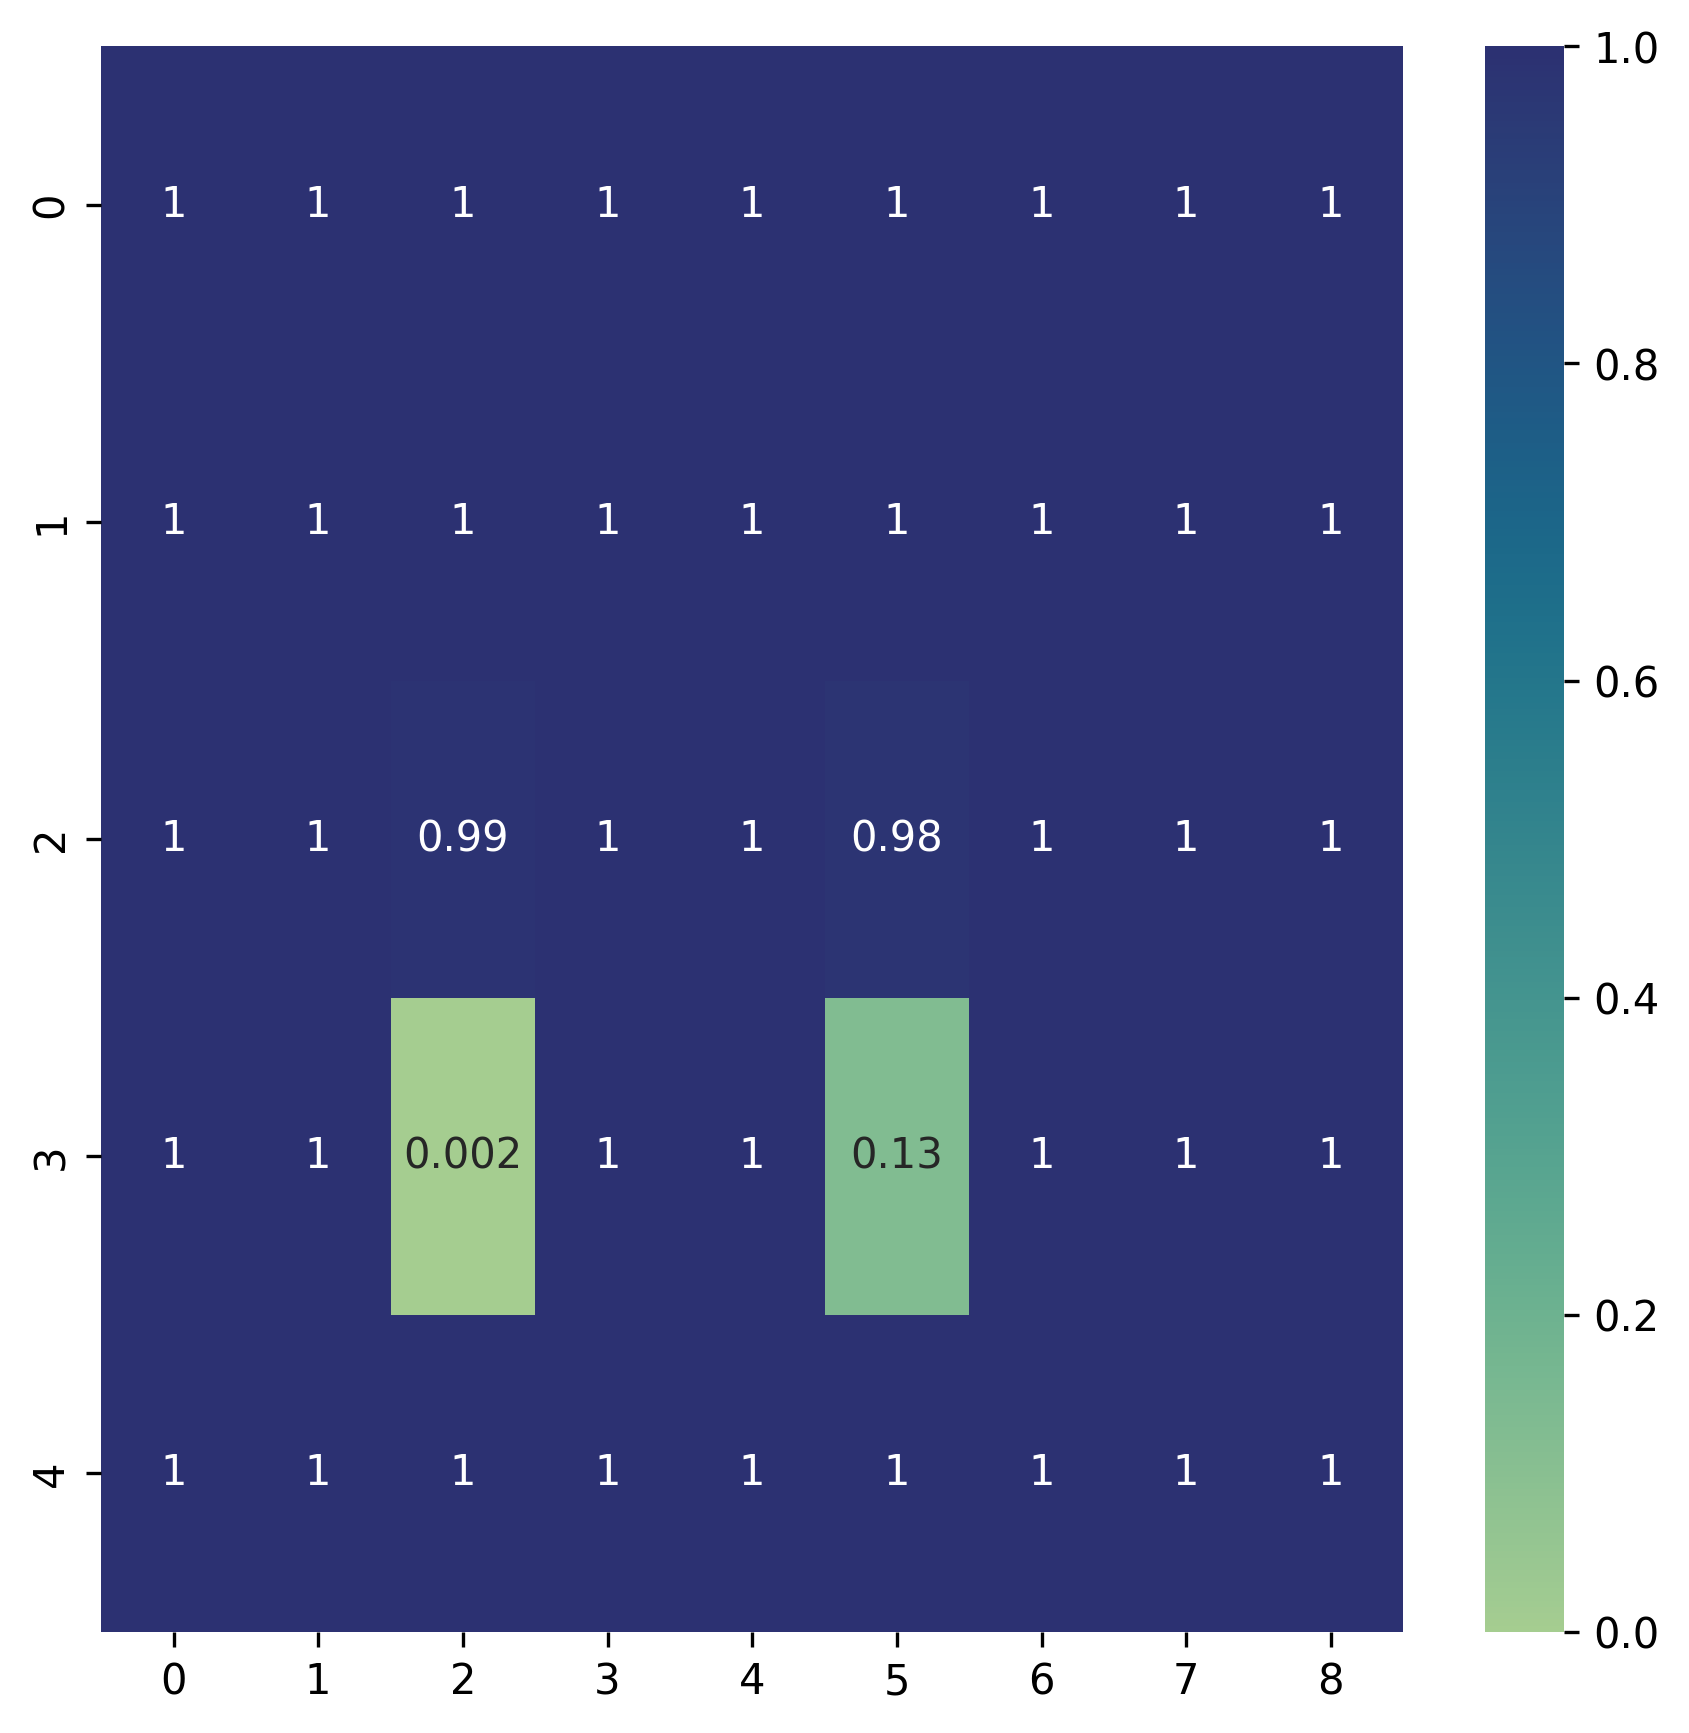

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

y_score_matrix = inference['y_score_matrix']
ax = sns.heatmap(y_score_matrix, annot=True, vmin=0, vmax=1, cmap="crest")

plt.show()

In [27]:
inference_pairs = inference['top_sentence_pairs']

html = '<table>'
html += f'<caption><strong>{len(inference_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'

attentions = inference['attention']

for pairs in inference_pairs:
    s = pairs['idx_sent.source']
    t = pairs['idx_sent.target']

    source_words = block_words['source'][s]
    target_words = block_words['target'][t]
    source_attention = attentions['source'][s, t]
    target_attention = attentions['target'][s, t]
    source_words = highlight(source_words, source_attention)
    target_words = highlight(target_words, target_attention)

    html += '<td>'+ source_words + ' '+ '<u>' + target_words + '</u>' +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

In [28]:
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.9, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.9)

def article_identity(df_article, article_id):
    """Reformat identity for article"""
    authors = df_article.loc[article_id,'authors']
    if len(authors) == 1:
        authors = authors[0]
    else:
        ', '.join(authors)
    year = df_article.loc[article_id,'publicationYear'].astype(str)
    title = df_article.loc[article_id,'title']
    return authors + '. ' + year + '. "' +  title + '"'

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'

source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
source_identity = article_identity(df_article, source_article_id)
target_identity = article_identity(df_article, target_article_id)

html += '<thead><tr><th>Source : '+source_identity+'</th> <th>Target : '+target_identity+'</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'


# Prepare the tokens
flat_block_words = {
    side : [token for sentence in block_words[side] for token in sentence] for side in block_words
}

flat_block_attention = { 
    side: [att for sentence in block_attentions[side] for att in sentence] for side in block_words
}

# First line : block text + score + type
html += '<tr>'

html += '<td>'+ highlight(flat_block_words['source'], flat_block_attention['source'])+ '</td>'
html += '<td>'+ highlight(flat_block_words['target'], flat_block_attention['target'])+ '</td>'

# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

html += '</tbody>'
html += '</table>'
display(HTML(html))



## Meta study

Predition score between sentence pairs from the same block

In [29]:
df_same_block_links = df_std_block_links[df_std_block_links['source.uid'] == df_std_block_links['target.uid']].copy() 





In [30]:
from tqdm.auto import tqdm

def inference_score(row): 
    # get uid
    block_uid = { side: link[f'{side}.uid'] for side in ['source', 'target']}

    # get token 'norm' (aka. normalized tokens for model)
    block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
    # batched inference from gpu model
    inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
    row['y_score_matrix'] = inference['y_score_matrix'].tolist()
    return row
    
tqdm.pandas(desc='inference_score')
df_same_block_links = df_same_block_links.progress_apply(inference_score,axis=1)








inference_score:   0%|          | 0/106 [00:00<?, ?it/s]

In [31]:
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['figure.dpi'] = 300

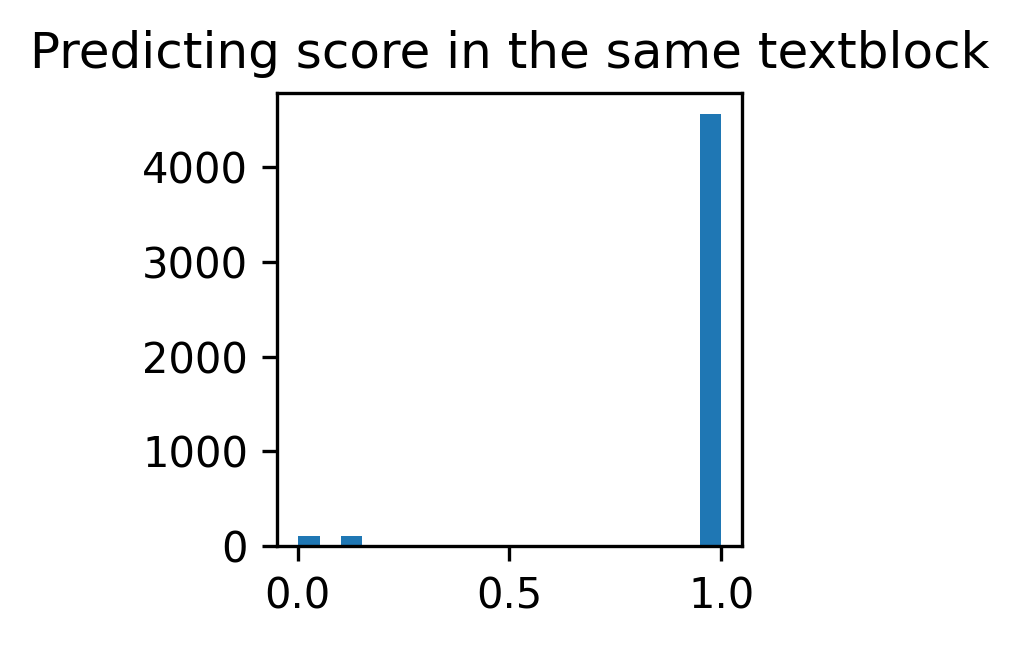

In [32]:
y_score = [y for y_score_matrix in df_same_block_links['y_score_matrix'] for y_line in y_score_matrix for y in y_line]

plt.hist(y_score, bins=20) 
plt.title("Predicting score in the same textblock") 
plt.show()           
           
           

Predition score between sentence pairs from different blocks

In [33]:
df_diff_block_links = df_std_block_links[df_std_block_links['source.uid'] != df_std_block_links['target.uid']].copy() 


In [34]:
tqdm.pandas(desc='inference_score')
df_diff_block_links = df_diff_block_links.progress_apply(inference_score,axis=1)

inference_score:   0%|          | 0/11130 [00:00<?, ?it/s]

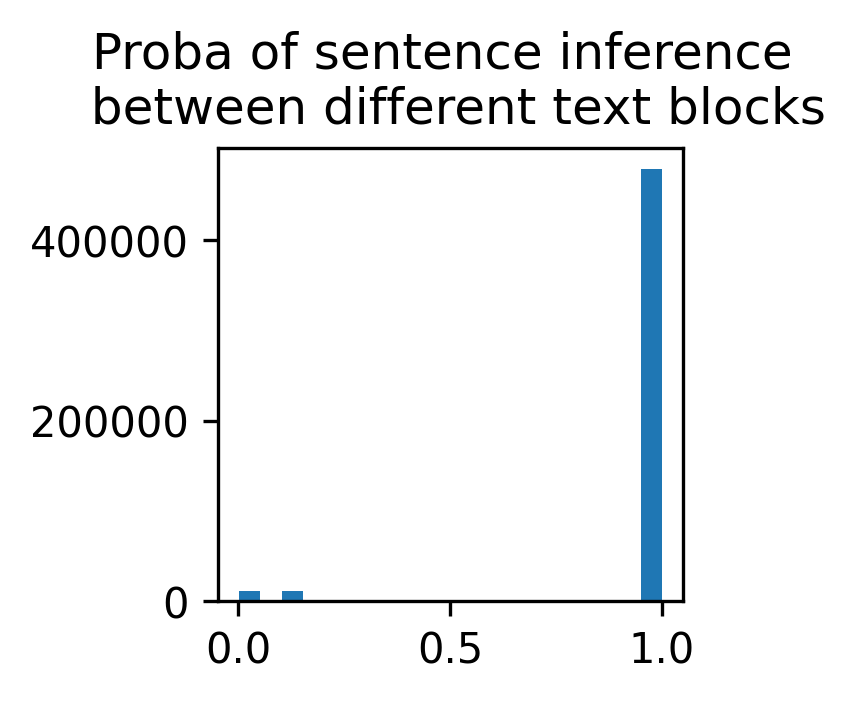

In [35]:
y_score = [y for y_score_matrix in df_diff_block_links['y_score_matrix'] for y_line in y_score_matrix for y in y_line]

plt.hist(y_score, bins=20) 
plt.title("Proba of sentence inference \n between different text blocks") 
plt.show()           
           


Link between blocks from different articles

In [36]:
df_diff_article_links = df_std_block_links[df_std_block_links['source.article.id'] != df_std_block_links['target.article.id']].copy() 


In [37]:
tqdm.pandas(desc='inference_score')
df_diff_article_links = df_diff_article_links.progress_apply(inference_score,axis=1)

inference_score:   0%|          | 0/9574 [00:00<?, ?it/s]

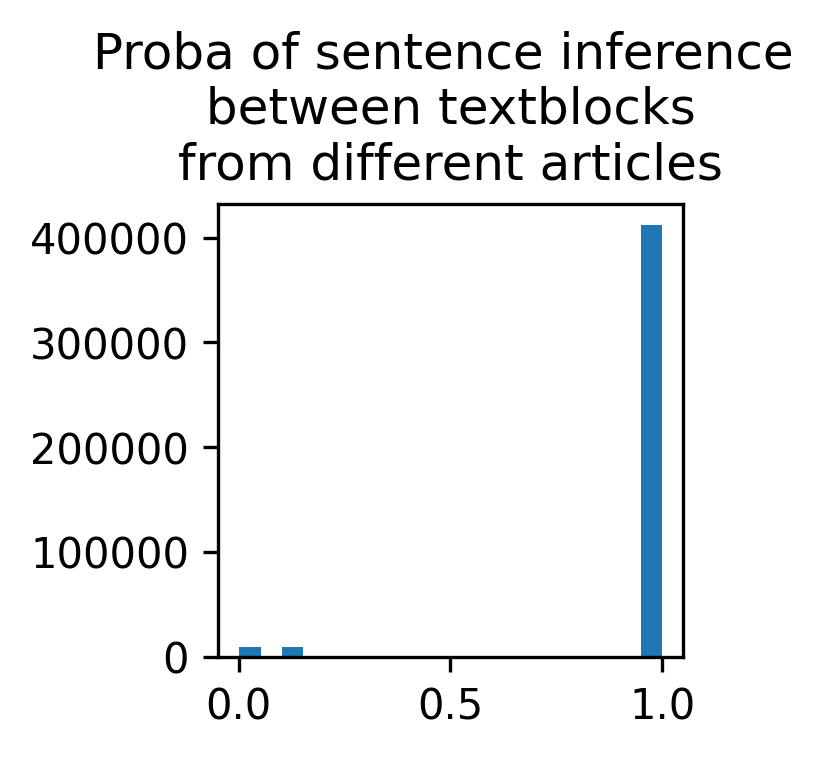

In [38]:
y_score = [y for y_score_matrix in df_diff_article_links['y_score_matrix'] for y_line in y_score_matrix for y in y_line]

plt.hist(y_score, bins=20) 
plt.title("Proba of sentence inference \n between textblocks \nfrom different articles") 
plt.show()           
        

# Evaluation in pre-established links

## QA Links

## Similarity Links

## TF-IDF